<a href="https://colab.research.google.com/github/Pedro-Ortega-G/P_ESTOCASTICOS/blob/main/gen_biomass_hmm_mlp_070325_1_ok_080325.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno carga desde el ambiente de Colab una base de datos (energy_dataseet.csv) de generación de energia eléctrica de diferentes tipos; de entre los tipos de generación disponibles en la bases de datos se selecciona "generation_biomass" como serie de tiempo a procesar; se le aplica un preprocesamiento rellenando los valores faltantes (interpolación lineal); se aplica un hmm (hidden markov model) que identifica automáticamente el número òptimo de estados y reconstruye la señal a partir del hmm generrado; se entrena (80% de datos para entrenamiento y 20% para validación) un mlp (2 capas densas de 64 y 32 neuronas con activación relu) con dos entradas (señal  original y señal  reconstruída con hmm), se compara el resultado con la señal original y se genera una visualización adicional de las últimas 200 muestras.
Adicionalmente se genera una visualización del error de la predicción y se confirma que tiene una distribución de probabilidad gausseana.


In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")


<ipython-input-1-b343a4d25277>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")


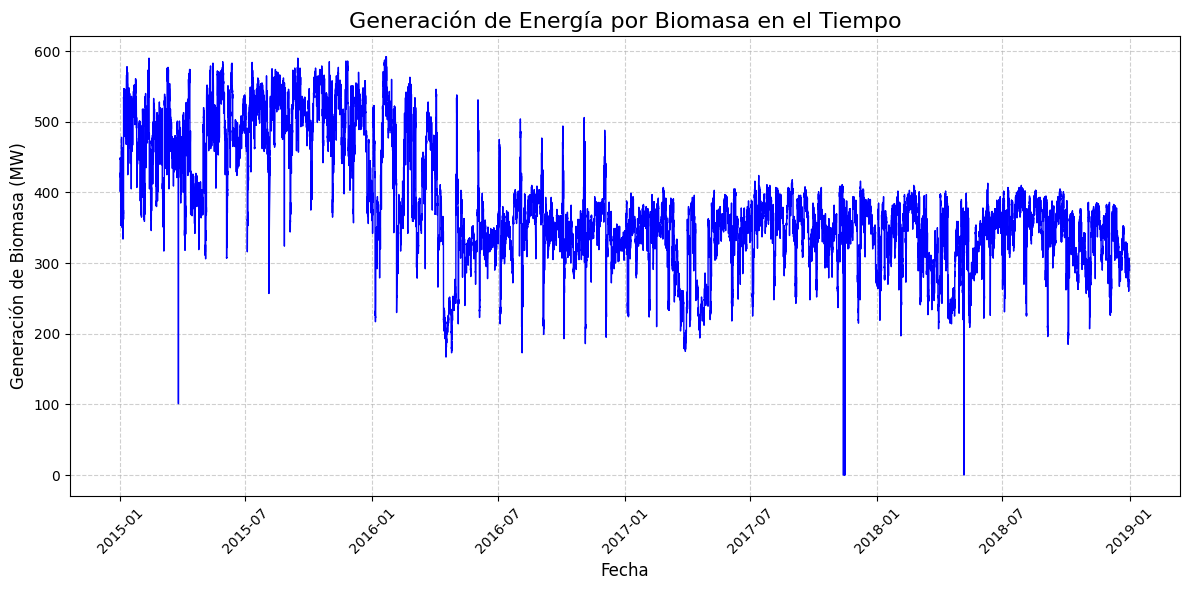

In [ ]:
# Importar matplotlib (si no está ya importado)
import matplotlib.pyplot as plt

# Crear la gráfica
plt.figure(figsize=(12, 6))  # Tamaño de la figura
plt.plot(df_biomass['time'], df_biomass['generation biomass'], color='blue', linewidth=1)

# Personalizar la gráfica
plt.title("Generación de Energía por Biomasa en el Tiempo", fontsize=16)  # Título
plt.xlabel("Fecha", fontsize=12)  # Etiqueta del eje X
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)  # Etiqueta del eje Y
plt.grid(True, linestyle='--', alpha=0.6)  # Cuadrícula para mejor visualización
plt.xticks(rotation=45)  # Rotar las fechas en el eje X para mejor legibilidad

# Mostrar la gráfica
plt.tight_layout()  # Ajustar el diseño para evitar recortes
plt.show()

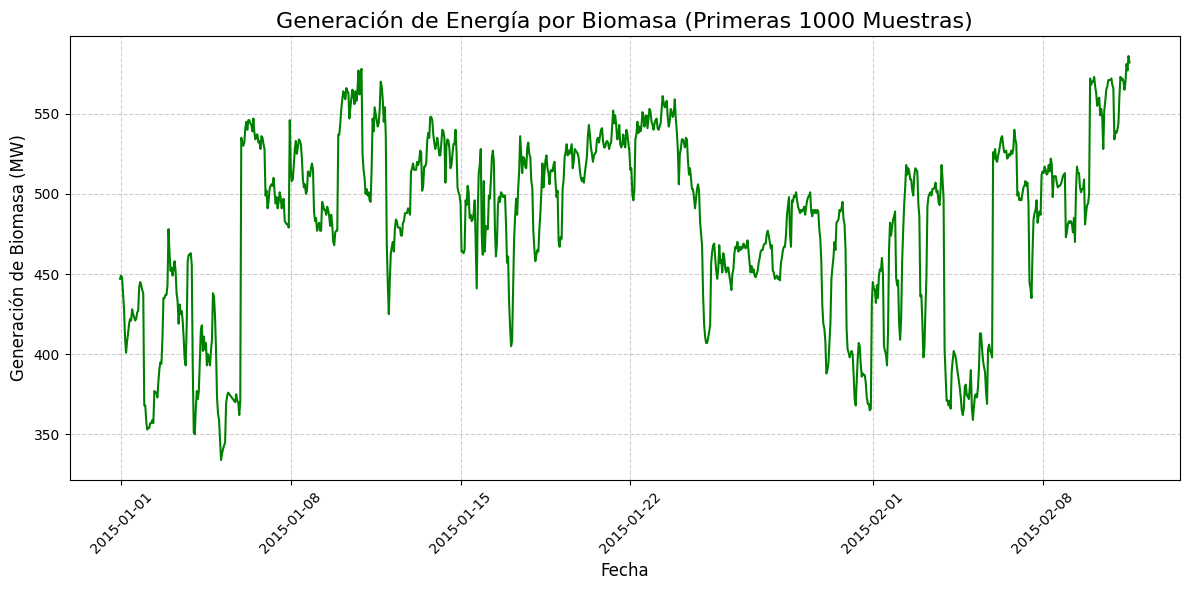

In [ ]:
# Seleccionar las primeras 1000 muestras
df_biomass_subset = df_biomass.iloc[:1000]

# Crear la gráfica
plt.figure(figsize=(12, 6))  # Tamaño de la figura
plt.plot(df_biomass_subset['time'], df_biomass_subset['generation biomass'], color='green', linewidth=1.5)

# Personalizar la gráfica
plt.title("Generación de Energía por Biomasa (Primeras 1000 Muestras)", fontsize=16)  # Título
plt.xlabel("Fecha", fontsize=12)  # Etiqueta del eje X
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)  # Etiqueta del eje Y
plt.grid(True, linestyle='--', alpha=0.6)  # Cuadrícula para mejor visualización
plt.xticks(rotation=45)  # Rotar las fechas en el eje X para mejor legibilidad

# Mostrar la gráfica
plt.tight_layout()  # Ajustar el diseño para evitar recortes
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.0 MB/s eta 0:00:00
Número óptimo de estados: 7
Matriz de probabilidad de transición de estados:
[[9.47300539e-01 6.98647028e-03 5.22136482e-05 2.74142868e-86
  7.90913886e-36 3.76957196e-02 7.96505774e-03]
 [1.49570531e-45 8.49503410e-01 2.28865625e-19 6.88253098e-02
  8.16712800e-02 1.74858710e-50 1.68348921e-17]
 [1.28139388e-02 1.15817005e-19 2.42795502e-06 1.07306213e-02
  4.82753127e-02 1.16007992e-01 8.12169707e-01]
 [2.25147969e-36 5.16915027e-02 1.68225711e-24 9.38131000e-01
  3.22503369e-16 1.01774978e-02 1.49638679e-34]
 [1.74145437e-02 5.44848996e-02 6.94618004e-08 1.53713438e-08
  8.56901648e-01 2.79358038e-11 7.11988239e-02]
 [2.62628168e-02 4.16538133e-03 8.83422925e-02 7.36810142e-92
  2.77508640e-14 8.81209349e-01 2.01601931e-05]
 [3.16358177e-13 2.60501226e-02 8.97595599e-01 3.79174418e-06
  7.62272534e-02 3.28944704e-06 1.19943885e-04]]


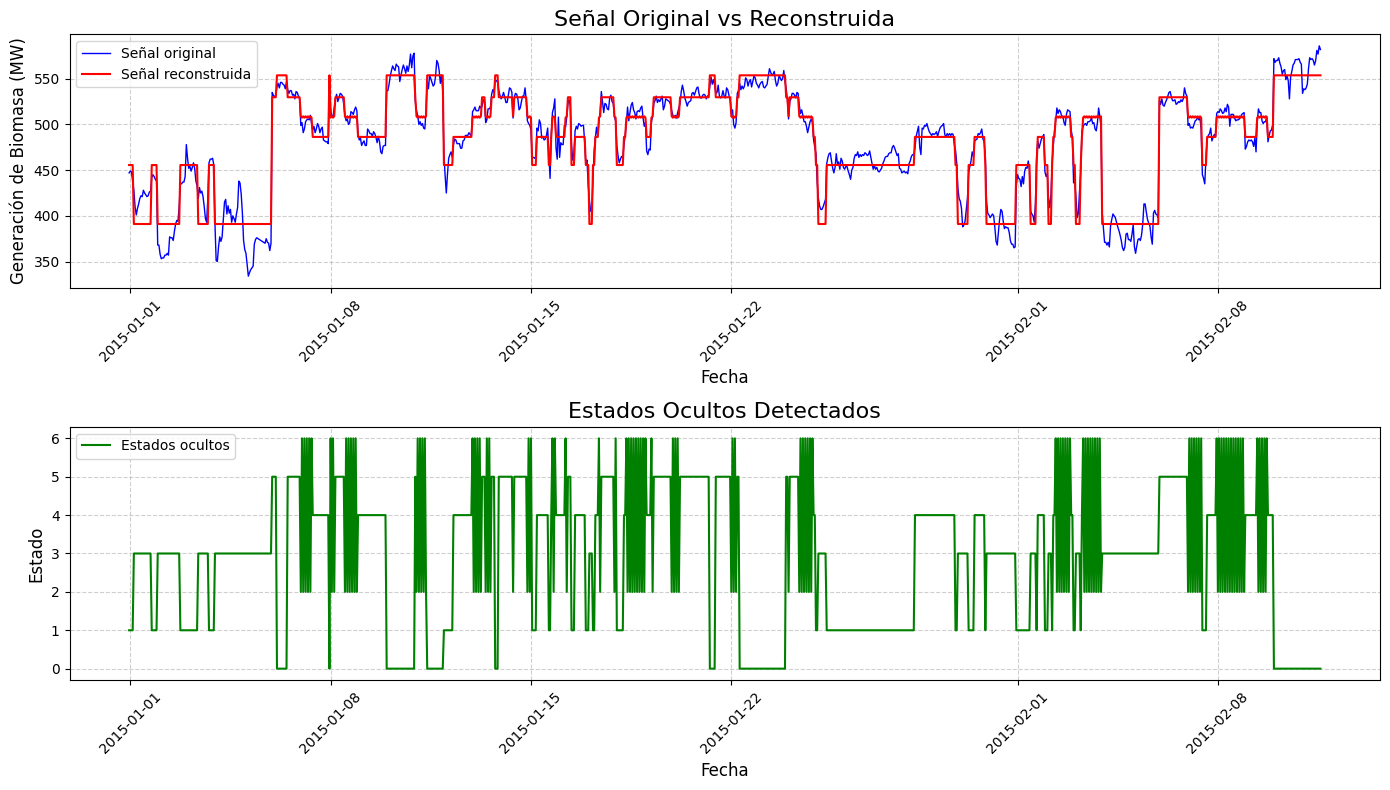

In [ ]:
!pip install hmmlearn
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Seleccionar las primeras 1000 muestras
df_biomass_subset = df_biomass.iloc[:1000]

# Preparar los datos para el HMM
data = df_biomass_subset['generation biomass'].values.reshape(-1, 1)  # Formato requerido por hmmlearn

# Función para encontrar el número óptimo de estados
def find_optimal_states(data, max_states=20):
    bic_scores = []
    for n_states in range(1, max_states + 1):
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
        model.fit(data)
        bic_scores.append(model.bic(data))
    return np.argmin(bic_scores) + 1, bic_scores

# Encontrar el número óptimo de estados
optimal_states, bic_scores = find_optimal_states(data)
print(f"Número óptimo de estados: {optimal_states}")

# Entrenar el HMM con el número óptimo de estados
hmm_model = hmm.GaussianHMM(n_components=optimal_states, covariance_type="diag", n_iter=100)
hmm_model.fit(data)

# Reconstruir la señal a partir del HMM
hidden_states = hmm_model.predict(data)
reconstructed_signal = hmm_model.means_[hidden_states].flatten()

# Matriz de probabilidad de transición de estados
transition_matrix = hmm_model.transmat_
print("Matriz de probabilidad de transición de estados:")
print(transition_matrix)

# Visualizar resultados
plt.figure(figsize=(14, 8))

# Gráfica de la señal original
plt.subplot(2, 1, 1)
plt.plot(df_biomass_subset['time'], data, label="Señal original", color="blue", linewidth=1)
plt.title("Señal Original vs Reconstruida", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)

# Gráfica de la señal reconstruida
plt.plot(df_biomass_subset['time'], reconstructed_signal, label="Señal reconstruida", color="red", linewidth=1.5)
plt.legend()

# Gráfica de los estados ocultos
plt.subplot(2, 1, 2)
plt.plot(df_biomass_subset['time'], hidden_states, label="Estados ocultos", color="green", linewidth=1.5)
plt.title("Estados Ocultos Detectados", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Estado", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

Número óptimo de estados: 10
Matriz de probabilidad de transición de estados:
[[8.52558812e-001 1.31586302e-090 2.25862609e-053 5.21476626e-002
  8.98096880e-003 5.91060991e-002 5.14084228e-003 2.07358595e-010
  1.53925139e-003 2.05263640e-002]
 [2.98686543e-074 1.53263076e-022 7.38167260e-001 7.13762977e-146
  7.37827082e-288 2.16901171e-053 2.61832740e-001 1.93476800e-186
  1.11923551e-013 3.18553206e-019]
 [4.69517121e-061 1.04980373e-008 1.00419780e-016 7.87795787e-135
  1.95151425e-214 6.56531485e-051 6.67629484e-028 1.55305536e-153
  7.48138586e-001 2.51861404e-001]
 [9.68815548e-002 2.20836200e-180 1.33747986e-122 1.11505566e-011
  1.27270939e-001 2.90303589e-061 7.76176864e-163 7.35672729e-001
  7.15312546e-253 4.01747771e-002]
 [2.90419976e-093 1.59115163e-082 7.47474277e-003 3.09042406e-021
  9.54454322e-001 2.57095671e-089 0.00000000e+000 3.80709349e-002
  3.09698924e-131 3.56082443e-058]
 [9.37350839e-002 2.72442533e-025 3.04777324e-003 1.67520562e-002
  8.20087547e-014 8.0

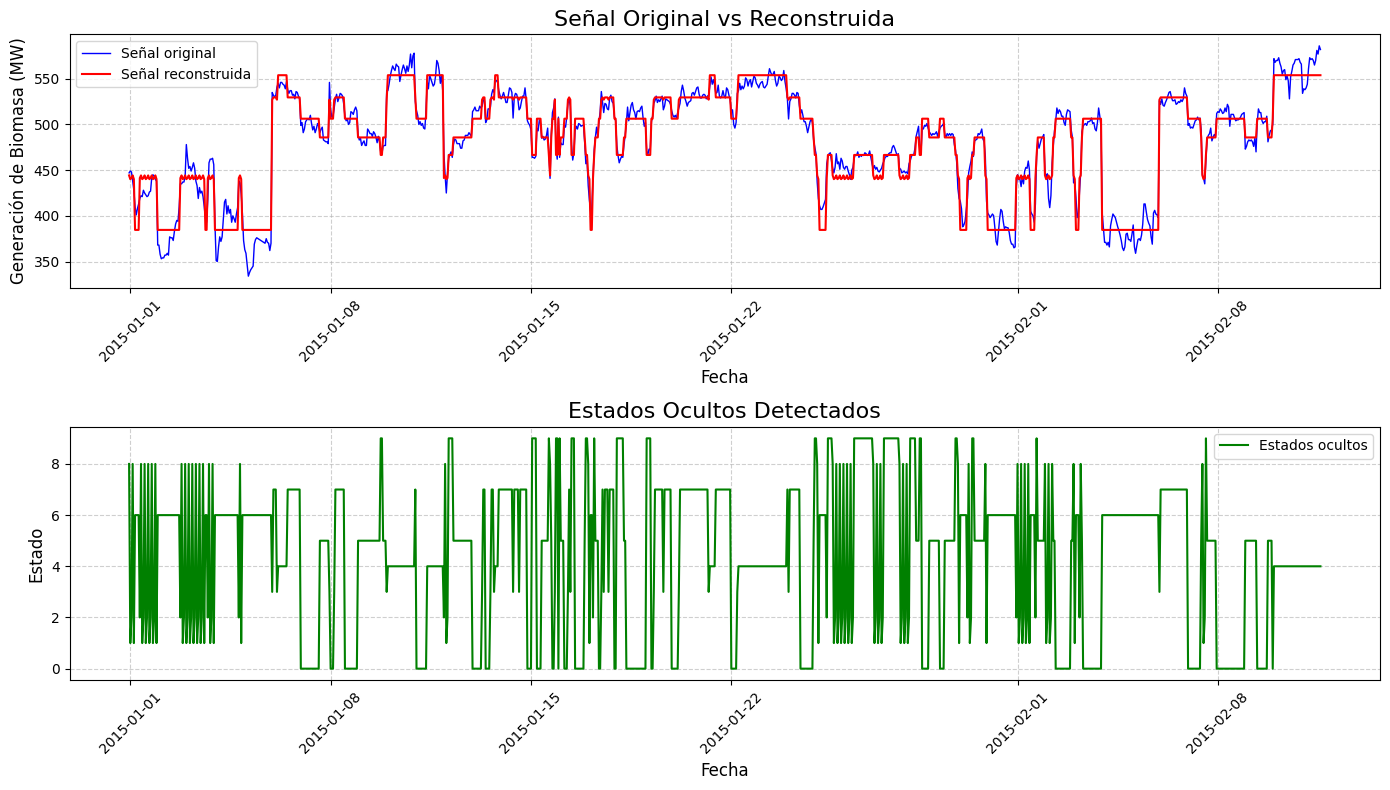

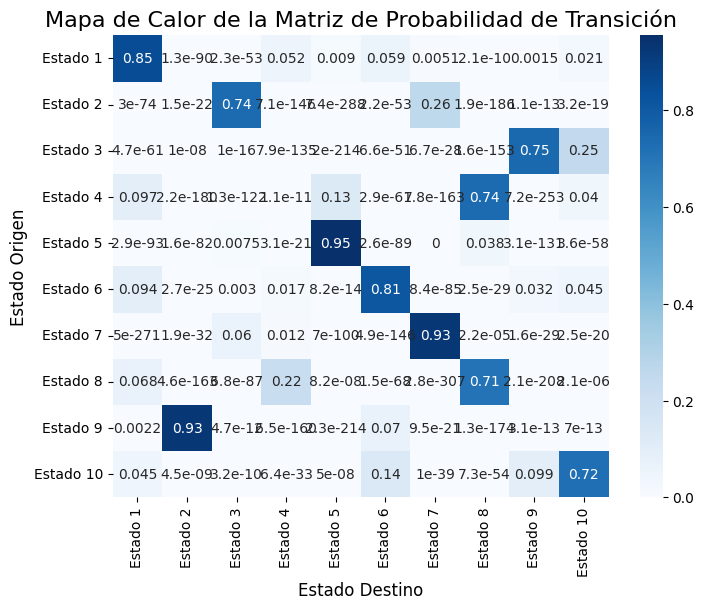

In [ ]:
# Instalar hmmlearn si no está instalado
try:
    from hmmlearn import hmm
except ModuleNotFoundError:
    !pip install hmmlearn
    from hmmlearn import hmm

# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Para el mapa de calor

# Seleccionar las primeras 1000 muestras
df_biomass_subset = df_biomass.iloc[:1000]

# Preparar los datos para el HMM
data = df_biomass_subset['generation biomass'].values.reshape(-1, 1)  # Formato requerido por hmmlearn

# Función para encontrar el número óptimo de estados
def find_optimal_states(data, max_states=20):
    bic_scores = []
    for n_states in range(1, max_states + 1):
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
        model.fit(data)
        bic_scores.append(model.bic(data))
    return np.argmin(bic_scores) + 1, bic_scores

# Encontrar el número óptimo de estados
optimal_states, bic_scores = find_optimal_states(data)
print(f"Número óptimo de estados: {optimal_states}")

# Entrenar el HMM con el número óptimo de estados
hmm_model = hmm.GaussianHMM(n_components=optimal_states, covariance_type="diag", n_iter=100)
hmm_model.fit(data)

# Reconstruir la señal a partir del HMM
hidden_states = hmm_model.predict(data)
reconstructed_signal = hmm_model.means_[hidden_states].flatten()

# Matriz de probabilidad de transición de estados
transition_matrix = hmm_model.transmat_
print("Matriz de probabilidad de transición de estados:")
print(transition_matrix)

# Visualizar resultados
plt.figure(figsize=(14, 8))

# Gráfica de la señal original vs reconstruida
plt.subplot(2, 1, 1)
plt.plot(df_biomass_subset['time'], data, label="Señal original", color="blue", linewidth=1)
plt.plot(df_biomass_subset['time'], reconstructed_signal, label="Señal reconstruida", color="red", linewidth=1.5)
plt.title("Señal Original vs Reconstruida", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()

# Gráfica de los estados ocultos
plt.subplot(2, 1, 2)
plt.plot(df_biomass_subset['time'], hidden_states, label="Estados ocultos", color="green", linewidth=1.5)
plt.title("Estados Ocultos Detectados", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Estado", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Mapa de calor para la matriz de transición
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap="Blues", cbar=True,
            xticklabels=[f"Estado {i+1}" for i in range(optimal_states)],
            yticklabels=[f"Estado {i+1}" for i in range(optimal_states)])
plt.title("Mapa de Calor de la Matriz de Probabilidad de Transición", fontsize=16)
plt.xlabel("Estado Destino", fontsize=12)
plt.ylabel("Estado Origen", fontsize=12)
plt.show()

Número óptimo de estados: 5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_original            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_reconstructed       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ input_original[0][0],  │
│                           │                        │                │ input_reconstructed[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │            192 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             33 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 232623.3438 - mae: 479.4124 - val_loss: 240740.8750 - val_mae: 486.4343
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 233976.4062 - mae: 480.7284 - val_loss: 239625.9062 - val_mae: 485.3330
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 233635.0938 - mae: 480.6341 - val_loss: 237482.7031 - val_mae: 483.2011
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 229733.3125 - mae: 476.4094 - val_loss: 233403.2188 - val_mae: 479.1125
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 223159.2344 - mae: 469.5505 - val_loss: 226391.7969 - val_mae: 471.9963
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 216483.5000 - mae: 462.4186 - val_loss: 215763.5000 - val_mae: 460.9868
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 207779.5938 - mae: 453.4252 - val_loss: 200984.6406 - val_mae: 445.2002
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 191936.6250 - mae: 436.

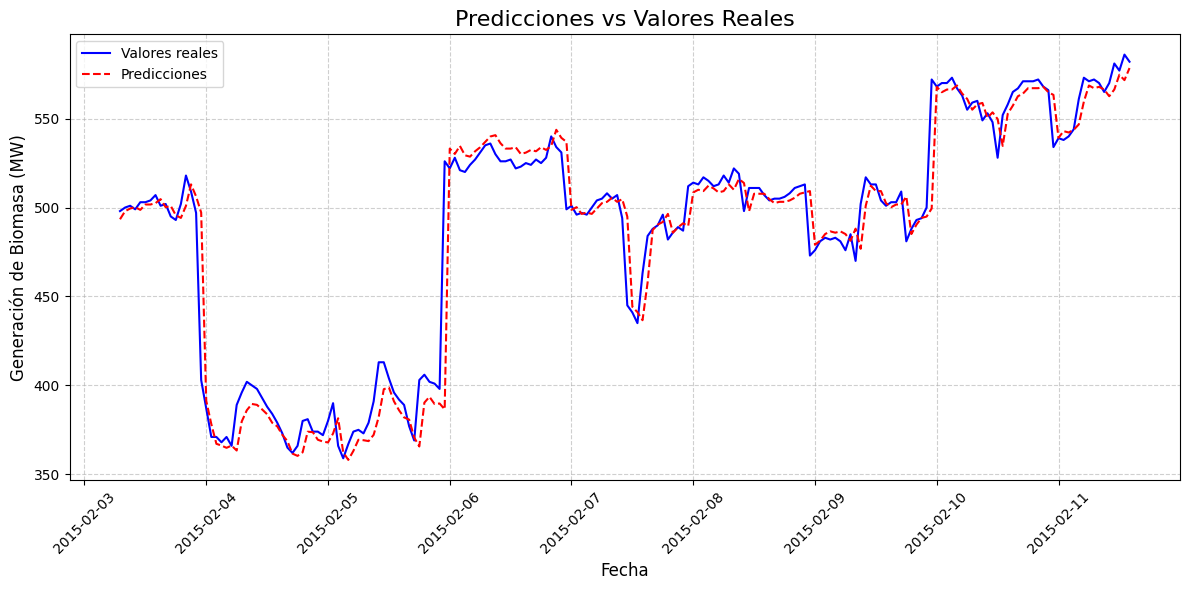

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Seleccionar las primeras 1000 muestras
df_biomass_subset = df_biomass.iloc[:1000]

# Preparar los datos para el HMM
data = df_biomass_subset['generation biomass'].values.reshape(-1, 1)

# Función para encontrar el número óptimo de estados
def find_optimal_states(data, max_states=20):
    bic_scores = []
    for n_states in range(1, max_states + 1):
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
        model.fit(data)
        bic_scores.append(model.bic(data))
    return np.argmin(bic_scores) + 1, bic_scores

# Encontrar el número óptimo de estados
optimal_states, bic_scores = find_optimal_states(data)
print(f"Número óptimo de estados: {optimal_states}")

# Entrenar el HMM con el número óptimo de estados
hmm_model = hmm.GaussianHMM(n_components=optimal_states, covariance_type="diag", n_iter=100)
hmm_model.fit(data)

# Reconstruir la señal a partir del HMM
hidden_states = hmm_model.predict(data)
reconstructed_signal = hmm_model.means_[hidden_states].flatten()

# Crear un DataFrame con las dos entradas
df_inputs = pd.DataFrame({
    'original_signal': df_biomass_subset['generation biomass'],
    'reconstructed_signal': reconstructed_signal
})

# Crear la variable objetivo (valor siguiente en la serie temporal)
df_inputs['target'] = df_inputs['original_signal'].shift(-1)

# Eliminar la última fila (NaN en la columna 'target')
df_inputs = df_inputs[:-1]

# Separar características (X) y objetivo (y)
X = df_inputs[['original_signal', 'reconstructed_signal']].values
y = df_inputs['target'].values

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalizar las entradas
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo MLP con dos entradas
input_original = Input(shape=(1,), name='input_original')
input_reconstructed = Input(shape=(1,), name='input_reconstructed')

# Concatenar las dos entradas
concat = concatenate([input_original, input_reconstructed])

# Capas densas
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear', name='output')(dense2)

# Crear el modelo
model = Model(inputs=[input_original, input_reconstructed], outputs=output)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(
    [X_train_scaled[:, 0], X_train_scaled[:, 1]], y_train,
    validation_data=([X_test_scaled[:, 0], X_test_scaled[:, 1]], y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluar el modelo
y_pred = model.predict([X_test_scaled[:, 0], X_test_scaled[:, 1]]).flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(df_biomass_subset['time'][-len(y_test):], y_test, label="Valores reales", color="blue")
plt.plot(df_biomass_subset['time'][-len(y_test):], y_pred, label="Predicciones", color="red", linestyle="--")
plt.title("Predicciones vs Valores Reales", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


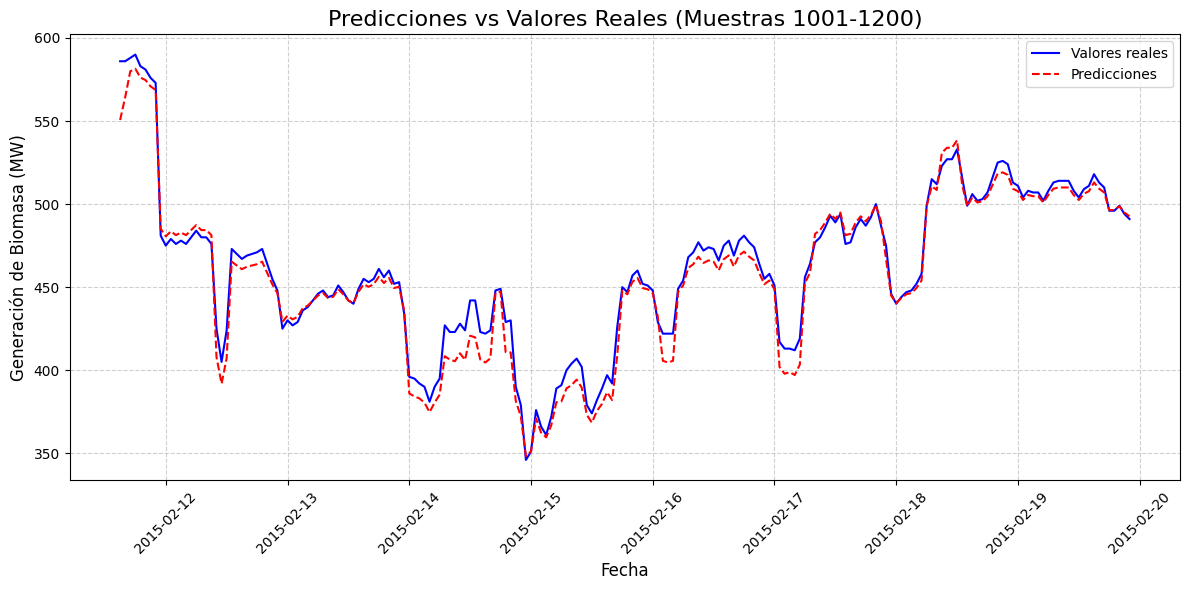

In [ ]:
# Seleccionar las muestras de 1001 a 1201
df_biomass_future = df_biomass.iloc[1000:1200]

# Preparar los datos para el HMM
data_future = df_biomass_future['generation biomass'].values.reshape(-1, 1)

# Reconstruir la señal usando el HMM previamente entrenado
hidden_states_future = hmm_model.predict(data_future)
reconstructed_signal_future = hmm_model.means_[hidden_states_future].flatten()

# Crear un DataFrame con las dos entradas para las nuevas muestras
df_future_inputs = pd.DataFrame({
    'original_signal': df_biomass_future['generation biomass'],
    'reconstructed_signal': reconstructed_signal_future
})

# Normalizar las entradas usando el mismo scaler del entrenamiento
X_future_scaled = scaler.transform(df_future_inputs[['original_signal', 'reconstructed_signal']].values)

# Generar predicciones con el modelo MLP
y_future_pred = model.predict([X_future_scaled[:, 0], X_future_scaled[:, 1]]).flatten()

# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(df_biomass_future['time'], df_future_inputs['original_signal'], label="Valores reales", color="blue")
plt.plot(df_biomass_future['time'], y_future_pred, label="Predicciones", color="red", linestyle="--")
plt.title("Predicciones vs Valores Reales (Muestras 1001-1200)", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


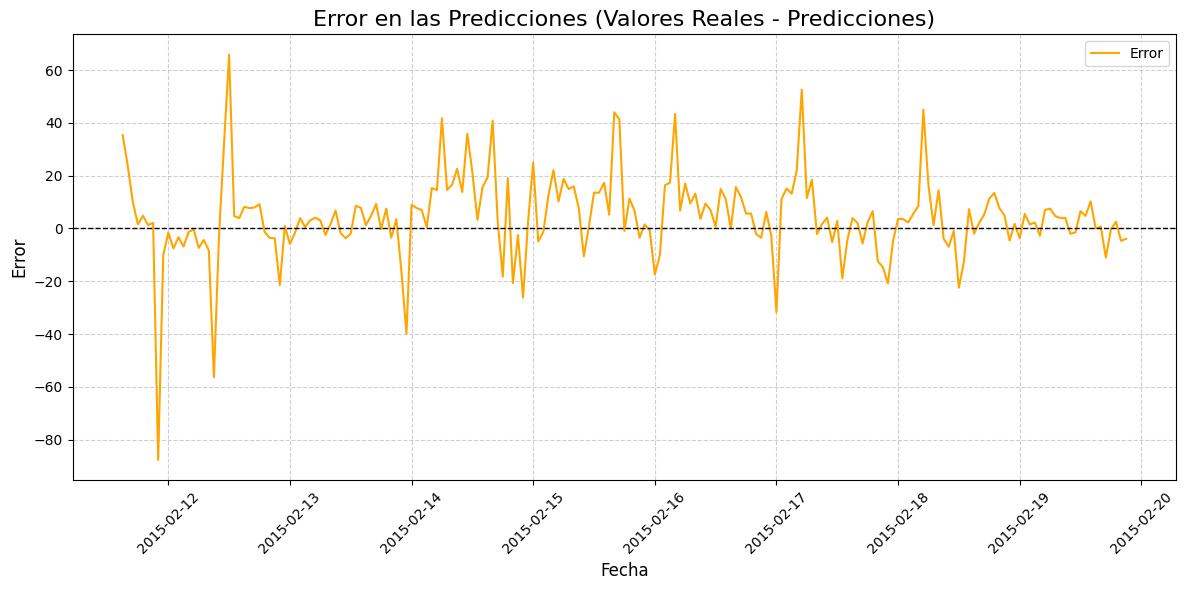

In [ ]:
# Seleccionar los siguientes 200 datos (muestras 1001 a 1201)
df_future_subset = df_biomass.iloc[1000:1200]

# Preparar los datos para el HMM
future_data = df_future_subset['generation biomass'].values.reshape(-1, 1)

# Reconstruir la señal usando el HMM entrenado previamente
future_hidden_states = hmm_model.predict(future_data)
future_reconstructed_signal = hmm_model.means_[future_hidden_states].flatten()

# Crear un DataFrame con las dos entradas para los datos futuros
df_future_inputs = pd.DataFrame({
    'original_signal': df_future_subset['generation biomass'],
    'reconstructed_signal': future_reconstructed_signal
})

# Crear una columna de "target" real para comparar (valor siguiente en la serie temporal)
df_future_inputs['target'] = df_future_subset['generation biomass'].shift(-1)
df_future_inputs = df_future_inputs[:-1]  # Eliminar la última fila (NaN en 'target')

# Extraer los valores reales (target) y normalizar las entradas
y_future_true = df_future_inputs['target'].values
X_future_scaled = scaler.transform(df_future_inputs[['original_signal', 'reconstructed_signal']].values)

# Generar predicciones con el modelo MLP
future_predictions = model.predict([X_future_scaled[:, 0], X_future_scaled[:, 1]]).flatten()

# Calcular el error (diferencia entre valores reales y predicciones)
errors = y_future_true - future_predictions

# Visualizar el error
plt.figure(figsize=(12, 6))
plt.plot(df_future_subset['time'][:-1], errors, label="Error", color="orange", linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Línea de referencia para error cero

# Personalización de la gráfica
plt.title("Error en las Predicciones (Valores Reales - Predicciones)", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

Longitud de los errores: 199
Primeros 5 errores: [35.3694458  23.63256836 10.04919434  1.53936768  4.82366943]


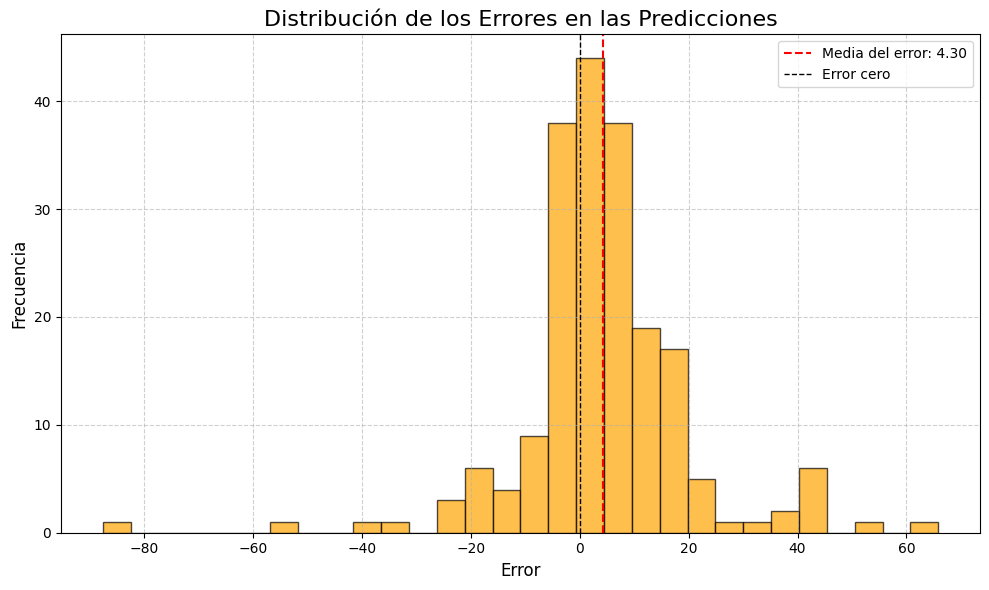

In [ ]:
# Calcular el error (diferencia entre valores reales y predicciones)
errors = y_future_true - future_predictions

# Verificar que los errores estén correctamente calculados
print(f"Longitud de los errores: {len(errors)}")
print(f"Primeros 5 errores: {errors[:5]}")

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color="orange", edgecolor="black", alpha=0.7)

# Personalización del histograma
plt.title("Distribución de los Errores en las Predicciones", fontsize=16)
plt.xlabel("Error", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar estadísticas básicas en la gráfica
mean_error = np.mean(errors)
std_error = np.std(errors)
plt.axvline(mean_error, color='red', linestyle='--', linewidth=1.5, label=f"Media del error: {mean_error:.2f}")
plt.axvline(0, color='black', linestyle='--', linewidth=1, label="Error cero")
plt.legend()

# Mostrar el histograma
plt.tight_layout()
plt.show()